In [36]:
! nvidia-smi

Thu Aug 12 03:49:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    41W / 250W |   1513MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
PATH = '..'
PATH = '/content/drive/MyDrive/Github/Ryles_Practice/'

In [39]:
!pip install konlpy

In [40]:
!cp '/content/drive/MyDrive/Github/Ryles_Practice/NLP/DL/preprocess.py' .

In [41]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

In [42]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'vla_' + string])
    plt.show()

In [43]:
DATA_IN_PATH = PATH+'DATA/data_in/'
DATA_OUT_PATH = PATH+'DATA/models/'
TRAIN_INPUTS = 'train_inputs.npy' # numpy 확장자 npy (구조 유지하는 binary 포맷)
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIG = 'data_configs.json'

In [44]:
SEED_NUM = 42
tf.random.set_seed(SEED_NUM)

In [45]:
import json
index_inputs = np.load(open(DATA_IN_PATH+TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH+TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(DATA_IN_PATH+TRAIN_TARGETS, 'rb'))
prepro_config = json.load(open(DATA_IN_PATH+DATA_CONFIG, 'r'))

In [46]:
MODEL_NAME = 'transformer_kor'
BATCH_SIZE = 24
MAX_SEQUENCE = 25
EPOCHS = 30
VALIDATION_SPLIT = 0.1

word2idx = prepro_config['word2idx']
idx2word = prepro_config['idx2word']

sos_idx = prepro_config['sos_symbol']
eos_idx = prepro_config['eos_symbol']
vocab_size = prepro_config['vocab_size']

# d-model: 단어의 차원, dff: feedforword 차원, num_head: 학습할 때 헤드(피쳐) 8개로
# maximum_position_encoding: 처음 입력 들어갈 때 해주는 위치 정보 인코딩

kargs = {'model_name':MODEL_NAME, 'num_layers':2, 'd_model':512, 'num_heads':8,
         'dff':2048, 'input_vocab_size':vocab_size, 'output_vocab_size':vocab_size,
         'maximum_position_encoding':MAX_SEQUENCE, 'end_token_idx':word2idx[eos_idx],
         'rate':0.1}

In [47]:
def create_padding_mask(seq):
    # seq 내의 내용이 pad인지 확인하여 pad 면 Ture(1), 아니면 False(0), 즉 마스킹하는 것
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    return seq[:, tf.newaxis, tf.newaxis, :] # 모든 행에 대해, 새로운 차원, 새로운 차원, 모든 열에 대해 적용
    # 결과적으로 (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)

In [48]:
def create_look_ahead_mask(size):
    # tf.linalg.band_part? 주는 값에 따라 트라이앵글 형태로 바꿔서 가져옴
    # tf ~ 로 lower triangle 만들고 그걸 1에서 빼서 upper 부분을 마스킹하려는 것
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

---
1. tf.linalg.band_part(input, num_lower, num_upper, name=None)
2. band[i, j, k, ..., m, n] = in_band(m, n) * input[i, j, k, ..., m, n]
3. in_band(m, n) = (num_lower < 0 || (m-n) <= num_lower)) && (num_upper < 0 || (n-m) <= num_upper)
---

In [49]:
def create_masks(input, target):
    enc_padding_mask = create_padding_mask(input)
    # decoder인데 왜 input? decoder 처음 input이 아니라 인코더 통해 받아서 더해주는 input에 대한 마스킹
    dec_padding_mask = create_padding_mask(input)
    # look_ahead_mask? decoding할 때 다음 단어의 attention 고려하지 않게 마스킹 하는 것
    # seq_len을 기준으로 마스킹 함
    look_ahead_mask = create_look_ahead_mask(tf.shape(target)[1])
    dec_target_padding_mask = create_padding_mask(target)
    # 원래 마스킹 해야하는 부분과 어텐션할 때 마스킹 해야하는 부분 모두를 마스킹할 수 있도록 combine
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

\begin{align}
  PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}})\\
  PE_{(pos,{2i+1})} = cos(pos/10000^{2i/d_{model}})
    \end{align}


In [50]:
def get_angles(pos, i, d_model):
    angle_rate = 1/np.power(10000,(2*i//2)/np.float(d_model))
    return pos*angle_rate

In [51]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


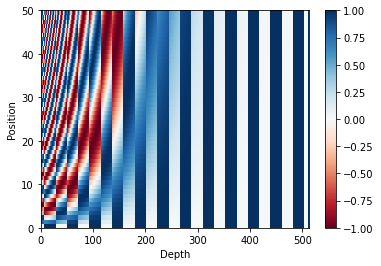

In [52]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim(0, 512)
plt.ylabel('Position')
plt.colorbar()
plt.show()

\begin{align}
  Attention(Q,K,V) = softmax(\frac{QK^t}{\sqrt{d_k}})V
    \end{align}

In [53]:
def scaled_dot_product_attention(q, k, v, mask):
    # transpose_a: a를 transpose / transpose_b: b를 tranpose -> k를 transpose 해줌
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 마스크 된 것에 엄청 작은 수를 곱해서 확률을 0에 가깝게 바꿔줌
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [54]:
class MultiHeadAttention(tf.keras.layers.Layer):
    ## ** -> 언패킹(딕셔너리에 대해)
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weight = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output, attention_weight

In [55]:
def position_wise_feed_forward_netword(**kargs):
    return tf.keras.Sequential([
                                tf.keras.layers.Dense(kargs['dff'], activation='relu'),
                                tf.keras.layers.Dense(kargs['d_model'])                                
    ])

In [56]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        # multi head attetion
        self.mha = MultiHeadAttention(**kargs)
        # feed forward
        self.ffn = position_wise_feed_forward_netword(**kargs)

        # Normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()

        # Dropout
        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        # 처음에 K, Q, V 같으니까 x, x, x
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)

        # residul connection
        out1 = self.layernorm1(x + attn_output)

        # feedforward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)

        # residul connection
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [57]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        # 모델 차원과 layer 정보 가져오기
        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        # 임베딩 (vocabsize, d_model)
        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)

        # 위치 정보 인코딩
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)
        
        # 인코더 레이어 만들어 주기
        self.enc_layers = [EncoderLayer(**kargs) for _ in range(self.num_layers)]

        # 드랍아웃
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        seq_len = tf.shape(x)[1]

        # 임베딩층
        x = self.embedding(x)

        # root(d_model)을 임베딩 값에 곱해준 것 (워드 임베딩 범위랑, 포지션 범위가 다르니까 그걸 맞춰주는 것 - 추측)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        # x와 포지션 인코딩 했던 것 더해주기
        x += self.pos_encoding[:, :seq_len, :]

        # 드랍아웃
        x = self.dropout(x)

        for layer in range(self.num_layers):
            x = self.enc_layers[layer](x, mask)

        return x


In [58]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)

        self.ffn = position_wise_feed_forward_netword(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.layernorm3 = tf.keras.layers.LayerNormalization()

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        attn1, attn_weight_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weight_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weight_block1, attn_weight_block2

In [59]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['output_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)
        
        self.dec_layers = [DecoderLayer(**kargs) for _ in range(self.num_layers)]

        self.drop_out = tf.keras.layers.Dropout(kargs['rate'])


    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weight = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.drop_out(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)
            attention_weight['decoder_layers{}_block1'.format(i+1)] = block1
            attention_weight['decoder_layers{}_block2'.format(i+1)] = block2

        return x, attention_weight

In [60]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__(name=kargs['model_name'])

        self.end_token_idx = kargs['end_token_idx']
        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)

        self.final_layer = tf.keras.layers.Dense(kargs['output_vocab_size'])

    def call(self, x):
        input, output = x

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(input, output)
        enc_output = self.encoder(input, enc_padding_mask)

        dec_output, _ = self.decoder(output, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output

    def inference(self, x):
        input = x
        output = tf.expand_dims([SOS_INDEX], 0)

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(input, output)
        enc_output = self.encoder(input, enc_padding_mask)

        predict_tokens = []
        for t in range(MAX_SEQUENCE):
            dec_output, _ = self.decoder(output, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]

            if pred_token == self.end_token_idx:
                break

            predict_tokens.append(pred_token)
            output = tf.expand_dims([SOS_INDEX] + predict_tokens, 0)
            _, look_ahead_mask, _ = create_masks(input, output)

        return predict_tokens

In [61]:
## logit이 True인 것은 안에서 softmax를 하겠다는 것
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

In [62]:
def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [63]:
model = Transformer(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=loss, metrics=[accuracy])

In [64]:
earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)

checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, 
                              save_best_only=True, 
                              save_weights_only=True)

In [65]:
history = model.fit([index_inputs, index_outputs], index_targets, 
                    batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/30
444/444 [==============================] - 67s 134ms/step - loss: 1.5408 - accuracy: 0.7931 - val_loss: 1.5996 - val_accuracy: 0.7962

Epoch 00001: val_loss improved from inf to 1.59956, saving model to /content/drive/MyDrive/Github/Ryles_Practice/DATA/models/transformer_kor/weights.h5
Epoch 2/30
444/444 [==============================] - 57s 129ms/step - loss: 1.2326 - accuracy: 0.8024 - val_loss: 1.4947 - val_accuracy: 0.8073

Epoch 00002: val_loss improved from 1.59956 to 1.49469, saving model to /content/drive/MyDrive/Github/Ryles_Practice/DATA/models/transformer_kor/weights.h5
Epoch 3/30
444/444 [==============================] - 57s 129ms/step - loss: 1.0707 - accuracy: 0.8121 - val_loss: 1.4583 - val_accuracy: 0.8157

Epoch 00003: val_loss improved from 1.49469 to 1.45829, saving model to /content/drive/MyDrive/Github/Ryles_Practice/DATA/models/transformer_kor/weights.h5
Epoch 4/30
444/444 [==============================] - 57s 129ms/step - loss: 0.9353 - accuracy: 0.

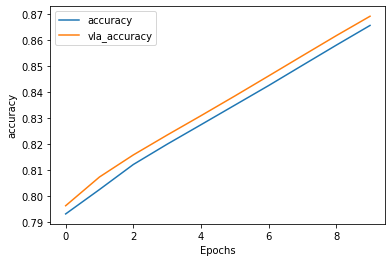

In [66]:
plot_graphs(history, 'accuracy')

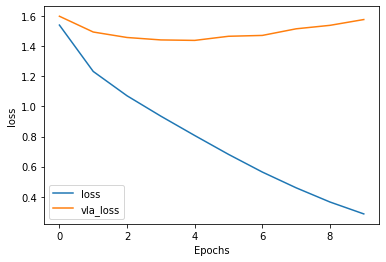

In [67]:
plot_graphs(history, 'loss')

In [68]:
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, 'weights.h5'))

In [69]:
word2idx = prepro_config['word2idx']
idx2word = prepro_config['idx2word']

In [77]:
text = "남자친구 승진 선물로 뭐가 좋을까?"
test_index_inputs, _ = enc_processing([text], word2idx)
outputs = model.inference(test_index_inputs)

print(" ".join([idx2word[str(o)] for o in outputs]))

마음 에 따라 다를 것 같아요
